# Pipeline
## Detección de rostros
1. Reproducir código de Santiago para detectar caras
2. Separar rectangulo de cara identificada

## Identificación de tapabocas
Como se sabe qué imágenes tienen tapabocas y cuales no, se puede etiquetar cada imagen con 1 si es con tapabocas y 0 de lo contrario. Por lo tanto los siguientes pasos son:

3. Obtener descriptores para cada imagen y construir dataframe con etiquetas
4. Probar algoritmos

## Opción 3. Use un proyecto anterior de la asignatura de aprendizaje de máquina (con Alex)

Algunos de ustedes, me han comentado acerca de dos proyectos de la asignatura de machine learning.  Uno es la detección de cuando una persona tiene tapabocas y cuando no. El otro es la detección y localización de los ojos en una imagen. Puede escoger cualquiera de estos dos proyectos, pero la idea aquí no es partir directamente de la imagen sino utilizar técnicas de procesamiento de imágenes y visión por computador (no deep learning) en combinación con métodos de machine learning (no necesariamente redes neuronales).  Tendrá que involucrar:

- Técnicas de preprocesado y postprocesado (si segmenta)
- Técnicas de segmentación y/o detección
- Es **obligatorio** extraer descriptores, ya sean locales o de toda la imagen (cuidado con la invarianza).
- Usar un pipeline de machine learning, involucrando diversas etapas y modelos (random forest, LDA, regresión logística, NN, etc) y escoger el mejor modelo. No olvide, evaluar sus resultados en un training y test sets.

Puede serle muy útil emplear un algoritmo de detección de rostros como "Viola-Jones". En un taller de MACC lo expliqué de forma muy sencilla ([en este video](https://youtu.be/0haEygYdHrw?list=PL0vATkTNKgo9NIY8oCL-pAfggflwHHA2O&t=1334)). [Este notebook](https://github.com/santialferez/tallerCV/blob/master/TallerCV.ipynb) (hacía el final) tiene un ejemplo sencillo con una foto mía de hace tiempo.

Para el problema de clasificación de tapabocas puede serle útil [este dataset](https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/face-mask-dataset.zip) (no use imágenes aumentadas).


In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import os
from copy import deepcopy
from skimage import io
from skimage.transform import resize
from skimage.measure import label, find_contours, moments_central, moments_normalized, moments_hu
from skimage import feature
from skimage import img_as_ubyte
from skimage.filters import sobel_v 

from scipy.stats import skew, kurtosis, entropy
from scipy.spatial import distance_matrix

# 1. Creación de función para detectar rectangulo de cara

Probaremos la función creada para dos imagenes: con y sin tapabocas

In [101]:
# FUNCIONES AUXILIARES
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def get_face(im, shape=[250,250],start="face"):
    """
    Detecta las caras en una imagen con algoritmo Viola-Jones
    
    args:
        im: imagen original en RGB
        shape: tamaño del rectangulo donde se detecta la cara
        start: indica si detecta la cara con el detector por defecto o a partir de los ojos,
                valores posibles: 'face','eyes', por defecto 'face'
    returns:
        seccion de la cara detectada en escala de grises
    """
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    detection = False
    if start == "face":
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        cuadrados = face_cascade.detectMultiScale(gray, 1.3, 5) # Aqui esta las coordenadas x,y,w,h
        if len(cuadrados) != 0:
            detection = True
            x,y,w,h = cuadrados[0]
    if start == "eyes" or detection == False:
        eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
        eyes = eye_cascade.detectMultiScale(gray, 1.3, 5)
        if len(eyes) == 0 or len(eyes) == 1:
            return None
        # Seleccion de los cuadrados asociados a los ojos a partir de su distancia
        true_eyes = select_eyes(eyes)
        x_min, x_max = [min(true_eyes[:,0]),max(true_eyes[:,0])]
        y_min = min(true_eyes[:,1])
        w_min,w_max = [min(true_eyes[:,2]), max(true_eyes[:,2])]
        h_max = max(true_eyes[:,3])

        x = x_min - w_min
        y = y_min - h_max
        w = (x_max + w_max) - (x_min - w_max)
        h = int(4*h_max)
        detection = True # tentativo
    # Seleccion en escala de grises de la cara
    #roi_gray = resize(gray[y:y+h, x:x+w],shape)
    roi_gray = gray[y:y+h, x:x+w]
    return  roi_gray

def get_statistic_features(imgs):
    """
    Calcula métricas estadisticas para un conjunto de imagenes
    
    args:
        imgs: arreglo con las imagenes en escala de grises
        
    returns:
        dataframe con las metricas estadísticas
    """
    #media,desviación estándar, skewness, curtósis, máximo, mínimo, contraste, uniformidad, entropía (ver diapositiva 64)
    n_col = 9
    mat = np.zeros([len(imgs),n_col])

    for i in range(len(imgs)):
        hist_data = np.histogram(imgs[i],bins=np.arange(256))
        I = (imgs[i]*255).round()
        p = dict()
        if I.shape[0]*I.shape[1] == 0:
            uniformity = np.nan
            mat[i,:] = np.array([np.nan]*mat.shape[1])
        else:
            uniformity = 0
            for j in range(256):
                p[j] = np.count_nonzero(I == j)/(I.shape[0]*I.shape[1])
                uniformity +=p[j]**2
            mat[i,0] = imgs[i].mean() # media
            mat[i,1] = imgs[i].std() # desviacion estandar
            mat[i,2] = skew(imgs[i].reshape(imgs[i].shape[0]*imgs[i].shape[1])) # skewness
            mat[i,3] = kurtosis(imgs[i].reshape(imgs[i].shape[0]*imgs[i].shape[1]))
            mat[i,4] = imgs[i].min() # minimo
            mat[i,5] = imgs[i].max() # maximo
            mat[i,6] = 1.0 - (1.0/(1+ imgs[i].std()**2)) # contraste
            # Uniformidad  y entropia con histogramas
            mat[i,7] = uniformity #uniformidad
            mat[i,8] = entropy([p[k] for k in p.keys()]) # entropia

    df = pd.DataFrame(mat,columns=["media","desviacion estándar", "skewness", "curtosis",
                                   "minimo",  "maximo", "contraste", "uniformidad", "entropia"])
    return df

def get_moments(imgs):
    """
    Calcula los 7 momentos para un conjunto de imagenes
    
    args:
        imgs: arreglo con las imagenes en escala de grises
        
    returns:
        dataframe con las metricas estadísticas
    """
    mat_moments = np.zeros([len(imgs),7])
    for i in range(len(imgs)):
        mu = moments_central(imgs[i])
        nu = moments_normalized(mu)
        mat_moments[i,:] = moments_hu(nu)

    moments = pd.DataFrame(mat_moments, columns = ["Momento "+str(i) for i in range(1,8)])
    return moments

def get_rotated_img_features(imgs):
    angulos = [0,45,90,135]
    contrastes = []
    disimilaridades = []
    homogeneidades = []
    ASMs = []
    energias = []
    correlaciones = []

    for i in range(len(imgs)):
        I = img_as_ubyte(imgs[i])
        cooc_matrices = []
        # Lista de matrices de coocurencias
        #P_ang = []
        for ang in angulos:
            coocc = feature.greycomatrix(I,angles=[ang], distances=[1], symmetric= True)
            cooc_matrices.append(coocc)
        # listas de metricas para los 4 angulos
        contr, dis, homs, asm, ene, corr = [[], [], [], [], [], []]

        # Calculo de metricas para imagenes rotadas
        for i in range(0,4):
            # Para contrastes
            contr.append(feature.greycoprops(cooc_matrices[i],prop="contrast")[0][0])
            # Para disimilaridades
            dis.append(feature.greycoprops(cooc_matrices[i],prop="dissimilarity")[0][0])
            # Para homogeneidades
            homs.append(feature.greycoprops(cooc_matrices[i],prop="homogeneity")[0][0])
            # Para ASMs
            asm.append(feature.greycoprops(cooc_matrices[i],prop="ASM")[0][0])
            # Para energias
            ene.append(feature.greycoprops(cooc_matrices[i],prop="energy")[0][0])
            # Para correlaciones
            corr.append(feature.greycoprops(cooc_matrices[i],prop="correlation")[0][0])
        # Se agrega a cada lista el promedio de las 4 imagenes rotadas
        contrastes.append(np.mean(contr))
        disimilaridades.append(np.mean(dis))
        homogeneidades.append(np.mean(homs))
        ASMs.append(np.mean(asm))
        energias.append(np.mean(ene))
        correlaciones.append(np.mean(corr))
    data = {"contraste": contrastes,
        "disimilaridad": disimilaridades,
       "homogeneidad": homogeneidades,
        "ASM": ASMs,
       "energia": energias,
       "correlacion": correlaciones,
       "textura": texturas}

    return pd.DataFrame.from_dict(data)

def select_eyes(eye_pos):
    """
    Retorna los vectores asociados a las coordenadas mas cercanas de ojos
    
    args:
        eye_pos: matriz de vectores de posiciones, ancho y alto de posibles ojos detectados
        
    returns:
        matriz con solo 2 vectores asociados a los ojos
    """
    dist = distance_matrix(eye_pos,eye_pos)
    a = list(set(np.sort(dist.reshape(1,-1)[0])))[1]
    idx = np.where(dist == a)[0]
    return eye_pos[idx]

In [3]:
# Primero lectura de imagenes
train_wm = "./face-mask-dataset/Dataset/train/train/without_mask"
train_m = "./face-mask-dataset/Dataset/train/train/with_mask"
#test_wm = "./"
#test = "./"
train_wm_images = load_images(train_wm)
train_m_images = load_images(train_m)

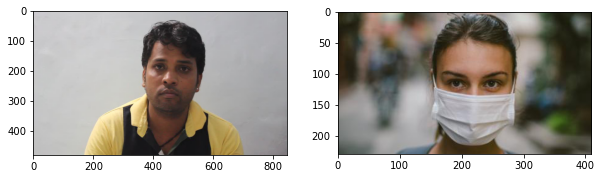

In [4]:
im1 = train_wm_images[0] # sin tapabocas
im2 = train_m_images[0] # con tapabocas
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(im1);
ax[1].imshow(im2);

### Aplicacion del algoritmo de Viola-Jones

In [5]:
#Cargando los clasificadores (en formato XML)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [6]:
gray_1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
gray_2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)

In [7]:
# Realiza la deteccion de rostros
faces_1 = face_cascade.detectMultiScale(gray_1, 1.3, 5)
eyes_2 = eye_cascade.detectMultiScale(gray_2, 1.3, 5)

In [20]:
true_eyes = select_eyes(eyes_2)

In [21]:
# Dibuja rectangulos en las caras y ojos
marked_1 = deepcopy(im1)
for (x,y,w,h) in faces_1:
    #marked_1 = cv2.rectangle(marked_1,(x,y),(x+w,y+h),(255,0,0),2)
    # Seleccion en escala de grises de la cara
    roi_gray_1 = gray_1[y:y+h, x:x+w]
    # Seleccion a color de la cara
    roi_color_1 = marked_1[y:y+h, x:x+w]

In [22]:
# Dibuja rectangulos en las caras y ojos

marked_2 = deepcopy(im2)

for (x,y,w,h) in true_eyes:
    marked_2 = cv2.rectangle(marked_2,(x,y),(x+w,y+h),(255,0,0),2)
    # Seleccion en escala de grises de la cara
    roi_gray_2 = gray_2[y:y+h, x:x+w]
    # Seleccion a color de la cara
    roi_color_2 = marked_2[y:y+h, x:x+w]

In [23]:
x_min, x_max = [min(true_eyes[:,0]),max(true_eyes[:,0])]
y_min = min(true_eyes[:,1])
w_min,w_max = [min(true_eyes[:,2]), max(true_eyes[:,2])]
h_max = max(true_eyes[:,3])

x = x_min - w_min
y = y_min - h_max
w = (x_max + w_max) - (x_min - w_max)
h = int(4*h_max)

marked_3 = deepcopy(im2)
marked_3 = cv2.rectangle(marked_3,(x,y),(x+w,y+h),(0,0,255),2)
# Seleccion en escala de grises de la cara
roi_gray_3 = gray_2[y:y+h, x:x+w]
# Seleccion a color de la cara
roi_color_3 = marked_3[y:y+h, x:x+w]

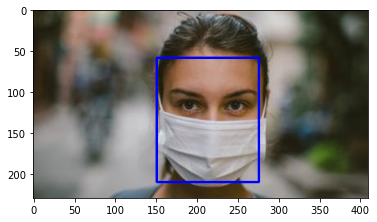

In [24]:
plt.imshow(marked_3);

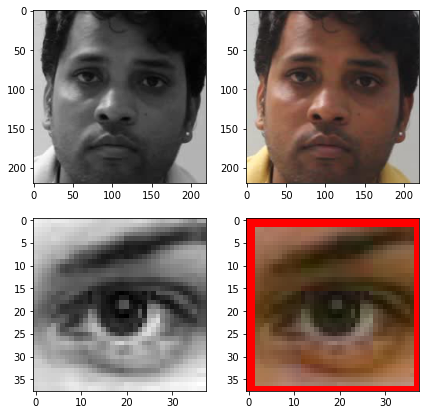

In [25]:
fig, ax = plt.subplots(2,2,figsize=(7,7))

ax[0,0].imshow(roi_gray_1, cmap="gray");
ax[0,1].imshow(roi_color_1);
ax[1,0].imshow(roi_gray_2, cmap="gray");
ax[1,1].imshow(roi_color_2);

Ya logramos implementar un codigo que detecte caras (con y sin tapabocas). Hay que confirmar que tan bien funciona aplicandolo al resto de las imágenes.


In [54]:
# detección de caras para todas las imagenes con y sin tapabocas
train_faces_no_mask = []
train_faces_mask = []

# Para caras sin tapabocas
print("Detectando caras...")
for i in range(len(train_wm_images)):
    I = get_face(train_wm_images[i],start="face")
    train_faces_no_mask.append(I)
print("Caras sin tapabocas detectadas!")

Detectando caras...
Caras sin tapabocas detectadas!


In [76]:
num_Nones = 0
train_no_mask = []
for i in range(len(train_faces_no_mask)):
    if train_faces_no_mask[i] is None:
        num_Nones +=1
    else:
        train_no_mask.append(train_faces_no_mask[i])
print("Cantidad de imagenes a las que no se pudo detectar cara (sin tapabocas): ",num_Nones)
print("Total: ",len(train_faces_no_mask))

Cantidad de imagenes a las que no se pudo detectar cara (sin tapabocas):  35
Total:  378


In [94]:
# Para caras con tapaocas
print("Detectando caras...")
for i in range(len(train_m_images)):
    train_faces_mask.append(get_face(train_m_images[i],start="face"))    
print("Caras con tapabocas detectadas!")

Detectando caras...
Caras con tapabocas detectadas!


In [95]:
num_Nones = 0
train_mask = []
for i in range(len(train_faces_mask)):
    if train_faces_mask[i] is None:
        num_Nones +=1
    else:
        train_mask.append(train_faces_mask[i])
print("Cantidad de imagenes a las que no se pudo detectar cara (con tapabocas): ",num_Nones)
print("Total: ",len(train_faces_mask))

Cantidad de imagenes a las que no se pudo detectar cara (con tapabocas):  212
Total:  760


**Nota:** Se descarta las imagenes en las que no se encontró la cara ni con facedetector ni a partir de los ojos.

# 2. Extracción de características

## 2.1 Descriptores estadísticos
**Nota:** confirmar si uniformidad está calculada correctamente

In [111]:
df_stat_no_mask = get_statistic_features(train_no_mask)

In [112]:
df_stat_mask = get_statistic_features(train_mask)

## 2.2 Momentos

In [113]:
moments_no_mask = get_moments(train_no_mask)
moments_mask = get_moments(train_mask) # varios momentos son NaN

In [115]:
print("NaNs en dataset de momentos:")
print(moments_mask.isna().sum())
print("Cantidad de imagenes con tapabocas: ",len(moments_mask))

NaNs en dataset de momentos:
Momento 1    18
Momento 2    18
Momento 3    18
Momento 4    18
Momento 5    18
Momento 6    18
Momento 7    18
dtype: int64
Cantidad de imagenes con tapabocas:  548


## 2.3 Descriptores adicionales

In [ ]:
df_